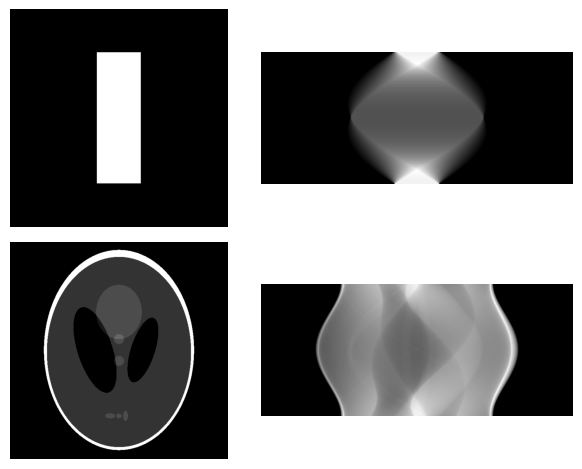

In [1]:
import numpy as np
from scipy import ndimage
from scipy.fft import fft, ifft
import cv2
from matplotlib import pyplot as plt
from skimage.transform import radon, iradon

def discreteRadonTransform(image, steps):  # 离散雷登变换
    len = image.shape[1]
    resRadon = np.zeros((steps, len))
    for s in range(steps):
        rotation = ndimage.rotate(image, -s * 180/steps, reshape=False).astype(np.float32)
        resRadon[steps - 1 - s, :] = np.sum(rotation, axis=0)
    return resRadon

def inverseRadonTransform(image, steps):  # 雷登变换反投影重建图像
    len = image.shape[1]
    backproject = np.zeros((steps, len, len))
    for s in range(steps):
        expandDims = np.expand_dims(image[steps - 1 - s, :], axis=0)
        repeat = expandDims.repeat(len, axis=0)
        backproject[s] = ndimage.rotate(repeat, s * 180/steps, reshape=False).astype(np.float32)
    invRadon = np.sum(backproject, axis=0)
    return invRadon

# def RampFilter(N):
#     n = np.concatenate(
#         (
#             np.arange(1, N / 2 + 1, 2, dtype=int),
#             np.arange(N / 2 - 1, 0, -2, dtype=int),
#         )
#     )
#     f = np.zeros(N)
#     f[0] = 0.25
#     f[1::2] = -1 / (np.pi * n) ** 2
#     rampfilter = 2 * np.real(fft(f))
#     return rampfilter
def RampFilter(N):
    rampfilter = np.zeros(N)
    rampfilter[0:int(N/2)+1] = np.arange(0, int(N/2)+1)
    for i in range(N-1, int(N/2), -1):
        rampfilter[i] = rampfilter[N-i]
    return rampfilter

def HammingFilter(N):
    n = np.arange(N)
    hammingfilter = 0.54 + 0.46*np.cos(2*np.pi*n/N)
    hammingfilter = hammingfilter * RampFilter(N)
    return hammingfilter

def filterInvRadonTransform(image, steps, Filter):  # 滤波反投影重建图像
    len = image.shape[1]
    backproject = np.zeros((steps, len, len))  # 反投影
    filter = Filter(len)
    for s in range(steps):
        value = image[steps - 1 - s, :]  # 投影值
        valueFiltered = np.real(ifft(fft(value) * filter))
        filterExpandDims = np.expand_dims(valueFiltered, axis=0)
        filterRepeat = filterExpandDims.repeat(len, axis=0)
        backproject[s] = ndimage.rotate(filterRepeat, s * 180/steps, reshape=False).astype(np.float32)
    filterInvRadon = np.sum(backproject, axis=0)
    return filterInvRadon

def pad_gray_image_to_sqrt2_size(image):
    original_size = image.shape[0]
    target_size = int(np.ceil(original_size * np.sqrt(2)))
    total_padding = target_size - original_size
    padding = total_padding // 2

    padded_image = cv2.copyMakeBorder(
        image,
        top=padding, bottom=padding,  # 上下填充
        left=padding, right=padding,  # 左右填充
        borderType=cv2.BORDER_CONSTANT,  # 使用常量填充
        value=0  # 灰度图填充0
    )
    
    return padded_image, padding

img1 = cv2.imread("Fig0533(a)(circle).tif", 0)
img2 = cv2.imread("Fig0534(a)(ellipse_and_circle).tif", 0)
img3 = cv2.imread("Fig0539(a)(vertical_rectangle).tif", 0)
img4 = cv2.imread("Fig0539(c)(shepp-logan_phantom).tif", 0)

img3_, img3_paddingsize = pad_gray_image_to_sqrt2_size(img3)
img4_, img4_paddingsize = pad_gray_image_to_sqrt2_size(img4)

img3radon = discreteRadonTransform(img3_, 360)
img4radon = discreteRadonTransform(img4_, 360)

plt.figure()
plt.subplot(221), plt.axis('off'), plt.imshow(img3, 'gray')
plt.subplot(222), plt.axis('off'), plt.imshow(img3radon, 'gray')
plt.subplot(223), plt.axis('off'), plt.imshow(img4, 'gray')
plt.subplot(224), plt.axis('off'), plt.imshow(img4radon, 'gray')
plt.tight_layout()


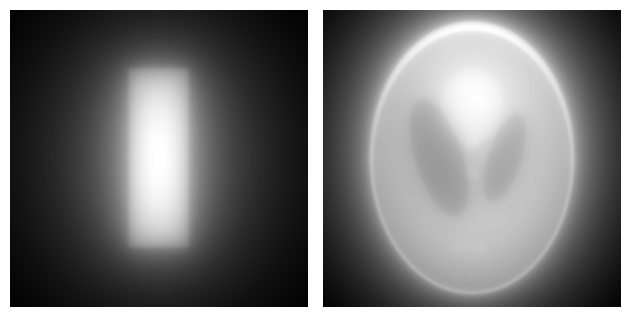

In [2]:

img3invradon = inverseRadonTransform(img3radon, 360)
img4invradon = inverseRadonTransform(img4radon, 360)

img3invradon = img3invradon[img3_paddingsize:img3invradon.shape[0] - img3_paddingsize, img3_paddingsize:img3invradon.shape[0] - img3_paddingsize]
img4invradon = img4invradon[img4_paddingsize:img4invradon.shape[0] - img4_paddingsize, img4_paddingsize:img4invradon.shape[0] - img4_paddingsize]

plt.figure()
plt.subplot(121), plt.axis('off'), plt.imshow(img3invradon, 'gray')
plt.subplot(122), plt.axis('off'), plt.imshow(img4invradon, 'gray')
plt.tight_layout()


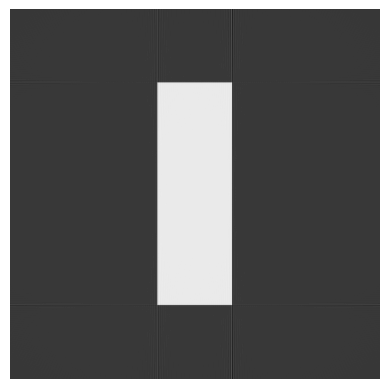

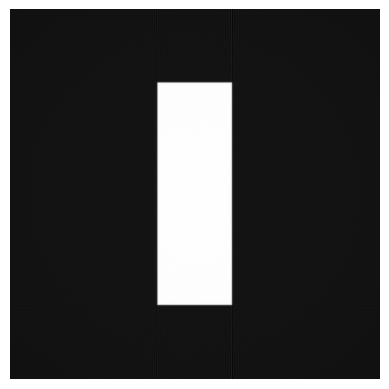

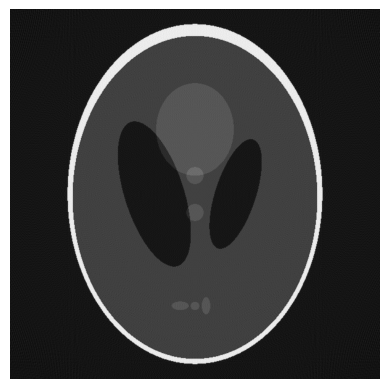

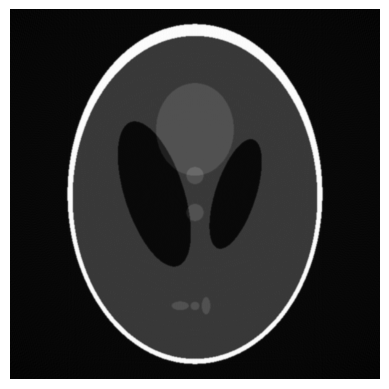

In [6]:
img3invradon_Rampfilter = filterInvRadonTransform(img3radon, 360, RampFilter)
img3invradon_Hammingfilter = filterInvRadonTransform(img3radon, 360, HammingFilter)
img4invradon_Rampfilter = filterInvRadonTransform(img4radon, 360, RampFilter)
img4invradon_Hammingfilter = filterInvRadonTransform(img4radon, 360, HammingFilter)

img3invradon_Rampfilter = img3invradon_Rampfilter[img3_paddingsize:img3invradon_Rampfilter.shape[0] - img3_paddingsize, img3_paddingsize:img3invradon_Rampfilter.shape[0] - img3_paddingsize]
img3invradon_Hammingfilter = img3invradon_Hammingfilter[img3_paddingsize:img3invradon_Hammingfilter.shape[0] - img3_paddingsize, img3_paddingsize:img3invradon_Hammingfilter.shape[0] - img3_paddingsize]
img4invradon_Rampfilter = img4invradon_Rampfilter[img4_paddingsize:img4invradon_Rampfilter.shape[0] - img4_paddingsize, img4_paddingsize:img4invradon_Rampfilter.shape[0] - img4_paddingsize]
img4invradon_Hammingfilter = img4invradon_Hammingfilter[img4_paddingsize:img4invradon_Hammingfilter.shape[0] - img4_paddingsize, img4_paddingsize:img4invradon_Hammingfilter.shape[0] - img4_paddingsize]

# plt.figure()
# plt.subplot(221), plt.axis('off'), plt.imshow(img3invradon_Rampfilter, 'gray')
# plt.subplot(222), plt.axis('off'), plt.imshow(img3invradon_Hammingfilter, 'gray')
# plt.subplot(223), plt.axis('off'), plt.imshow(img4invradon_Rampfilter, 'gray')
# plt.subplot(224), plt.axis('off'), plt.imshow(img4invradon_Hammingfilter, 'gray')
# plt.tight_layout()
plt.axis('off')
plt.imshow(img3invradon_Rampfilter, 'gray')
plt.figure()
plt.axis('off')
plt.imshow(img3invradon_Hammingfilter, 'gray')
plt.figure()
plt.axis('off')
plt.imshow(img4invradon_Rampfilter, 'gray')
plt.figure()
plt.axis('off')
plt.imshow(img4invradon_Hammingfilter, 'gray')